In [1]:
from context import *

## Set of available LED

In [2]:
mpeaks = [360, 380, 415, 470, 505, 530, 565, 617]
mnames = ['duv', 'uv', 'violet', 'blue', 'cyan', 'green', 'lime', 'orange']
np.random.seed(5)
intensity_bounds=(
    np.zeros(len(mpeaks)),  
    (np.random.random(len(mpeaks)) + np.arange(len(mpeaks))/len(mpeaks) + 0.5) * 10
)
measured_spectra = dreye.get_led_spectra_container(
    mpeaks, 
    names=mnames, 
    intensity_bounds=intensity_bounds, 
    output_bounds=(0, 5)
)

In [3]:
colors = sns.color_palette(
    'rainbow', 
    len(mpeaks)
)
mcmap = dict(zip(mnames, colors))

## Spectra of LEDs used for fitting

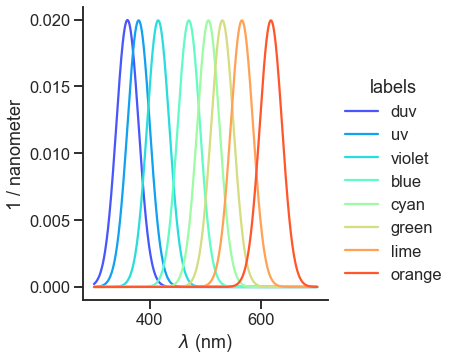

In [4]:
measured_spectra.normalized_spectra.plot(palette=mcmap)

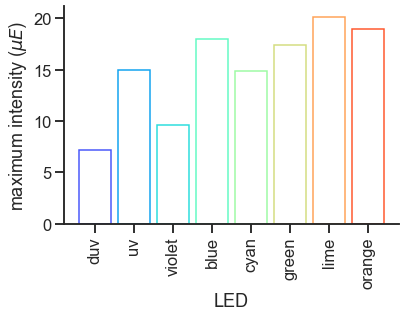

In [5]:
# intensity range of LEDs
plt.bar(
    np.arange(len(mpeaks)),
    measured_spectra.intensity_bounds[1], 
    color='white', edgecolor=mcmap.values()
)
plt.xticks(np.arange(len(mpeaks)), mcmap, rotation='vertical')
plt.xlabel('LED')
plt.ylabel(r'maximum intensity ($\mu E$)')
sns.despine()

In [6]:
m = 4

In [7]:
combos = np.array([
    [True, False, True, True, False, False, True, False], 
    [True, True, True, False, False, False, False, True], 
    [False, True, False, True, False, True, False, True], 
    [True, False, False, True, False, False, True, True], 
    [True, False, True, True, False, False, False, True], 
    [True, False, False, True, False, True, False, True],
    [True, False, True, False, True, False, False, True], 
    [False, True, True, False, True, False, False, True], 
    [True, False, False, False, True, False, True, True], 
    [False, True, False, True, False, False, True, True],
])
n_combos = len(combos)

In [8]:
n_combos

10

In [9]:
metrics1 = dreye.MeasuredSpectraMetrics(
    combos, 
    fish_log_model, measured_spectra
)
metrics2 = dreye.MeasuredSpectraMetrics(
    combos, 
    fly_log_model, measured_spectra
)

In [10]:
metrics1.compute_as_peaks()

Index(['duv', 'violet', 'blue', 'lime'], dtype='object')

In [11]:
metrics2.compute_as_peaks()

Index(['duv', 'uv', 'violet', 'orange'], dtype='object')

In [12]:
def pca(X):
    X = np.log(X+1)/np.log(2)
    cov = X.T @ X
    eigval, eigvec = np.linalg.eig(cov)
    argsort = np.argsort(eigval)[::-1]
    eigval = eigval[argsort]
    eigvec = eigvec[:, argsort]
    evar_ratio = eigval/np.sum(eigval)
    return eigvec

In [13]:
Bnames = ['achr', 'c1', 'c2', 'c3']

In [20]:
def get_df(metrics, name):
    df_mw = metrics.get_excitation_metrics(
        metric='mean_width',
        normalize=True, 
        B=np.eye(n), 
        B_name='prs'
    )
    df_gamut = metrics.get_excitation_metrics(
        metric='gamut',
        normalize=True, 
        nonlin=lambda x: np.maximum(x + 4, 0), # accuracy of -4 for excitations
        relative=False
    )
    df = pd.concat([df_mw, df_gamut])

    pcs = pca(metrics.photoreceptor_model.sensitivity.magnitude)
    for idx, bname in enumerate(Bnames):
        df_ = metrics.get_excitation_metrics(
            metric='mean_width', 
            normalize=True, 
            B=pcs[:, idx], 
            B_name=bname
        )
        df = df.append(df_, ignore_index=True)
        
    df['name'] = name
    df['mname'] = df.apply(
        lambda x: x['metric_name'] if x['transformation'] is None else x['transformation'], 
        axis=1
    )
    return df

In [21]:
df1 = get_df(metrics1, 'zebrafish')
df2 = get_df(metrics2, 'fruit fly')
df = pd.concat([df1, df2])

In [22]:
pdf = df.pivot(
    ['light_combos'], 
    ['name', 'mname'], 
    'metric'
)
pdf

name                   zebrafish                                          \
mname                        prs     gamut      achr        c1        c2   
light_combos                                                               
duv+blue+green+orange   0.802564  0.833860  0.755316  0.844360  0.721103   
duv+blue+lime+orange    0.849802  1.000000  0.877867  0.857518  0.727344   
duv+cyan+lime+orange    1.000000  0.883528  1.000000  1.000000  1.000000   
duv+uv+violet+orange    0.533520  0.333708  0.840443  0.365484  0.310565   
duv+violet+blue+lime    0.612923  0.526544  0.749639  0.544214  0.568499   
duv+violet+blue+orange  0.626466  0.551201  0.720844  0.502613  0.599445   
duv+violet+cyan+orange  0.637675  0.605887  0.840524  0.589081  0.519948   
uv+blue+green+orange    0.832760  0.750706  0.844948  0.866173  0.679628   
uv+blue+lime+orange     0.840253  0.759531  0.897421  0.867928  0.688763   
uv+violet+cyan+orange   0.650125  0.574523  0.758033  0.605244  0.544871   

name                             fruit fly                                \
mname                         c3       prs     gamut      achr        c1   
light_combos                                                               
duv+blue+green+orange   0.759964  0.987918  0.983019  0.879551  0.999560   
duv+blue+lime+orange    0.747732  0.950233  0.903856  0.809732  1.000000   
duv+cyan+lime+orange    1.000000  1.000000  1.000000  0.844231  0.980754   
duv+uv+violet+orange    0.321861  0.745961  0.418370  0.810361  0.625453   
duv+violet+blue+lime    0.461931  0.812210  0.616478  0.759245  0.770755   
duv+violet+blue+orange  0.460078  0.908367  0.613489  0.993382  0.744338   
duv+violet+cyan+orange  0.428283  0.887164  0.718789  0.848522  0.790866   
uv+blue+green+orange    0.662248  0.936638  0.814467  0.899333  0.890182   
uv+blue+lime+orange     0.727751  0.984215  0.849750  0.981447  0.949222   
uv+violet+cyan+orange   0.404753  0.927217  0.650834  1.000000  0.856776   

name                                        
mname                         c2        c3  
light_combos                                
duv+blue+green+orange   0.869341  0.807156  
duv+blue+lime+orange    0.903962  0.830010  
duv+cyan+lime+orange    1.000000  1.000000  
duv+uv+violet+orange    0.465647  0.195765  
duv+violet+blue+lime    0.733970  0.521919  
duv+violet+blue+orange  0.790761  0.417897  
duv+violet+cyan+orange  0.766007  0.598595  
uv+blue+green+orange    0.765909  0.744754  
uv+blue+lime+orange     0.728923  0.831979  
uv+violet+cyan+orange   0.768882  0.646394

In [23]:
pdf['zebrafish'].sum(axis=1).idxmax()

'duv+cyan+lime+orange'

In [24]:
pdf['fruit fly'].sum(axis=1).idxmax()

'duv+cyan+lime+orange'

Text(29.33387500000005, 0.5, 'LED combination')

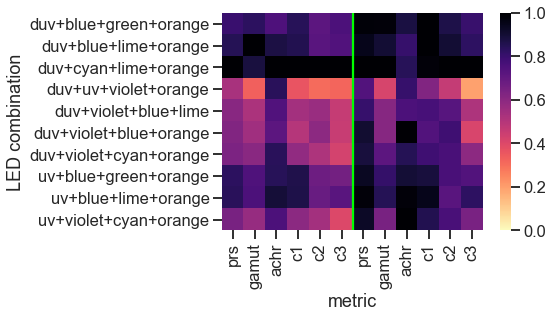

In [28]:
sns.heatmap(
    pdf, 
    vmin=0, vmax=1, 
    cmap='magma_r', 
    xticklabels=pdf.columns.get_level_values(-1), 
    square=True
)
plt.axvline(len(pdf.columns)//2, color='lime')
plt.xlabel('metric')
plt.ylabel('LED combination')